In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# TTC station locations

In [5]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')

In [6]:
# radius in km
radius = (stations_area.to_crs(epsg_2d)['geometry'].iloc[0].area / np.pi)**0.5 / 10**3

Text(0.5, 1.0, 'TTC subway stations with surrounding radius of 0.40km')

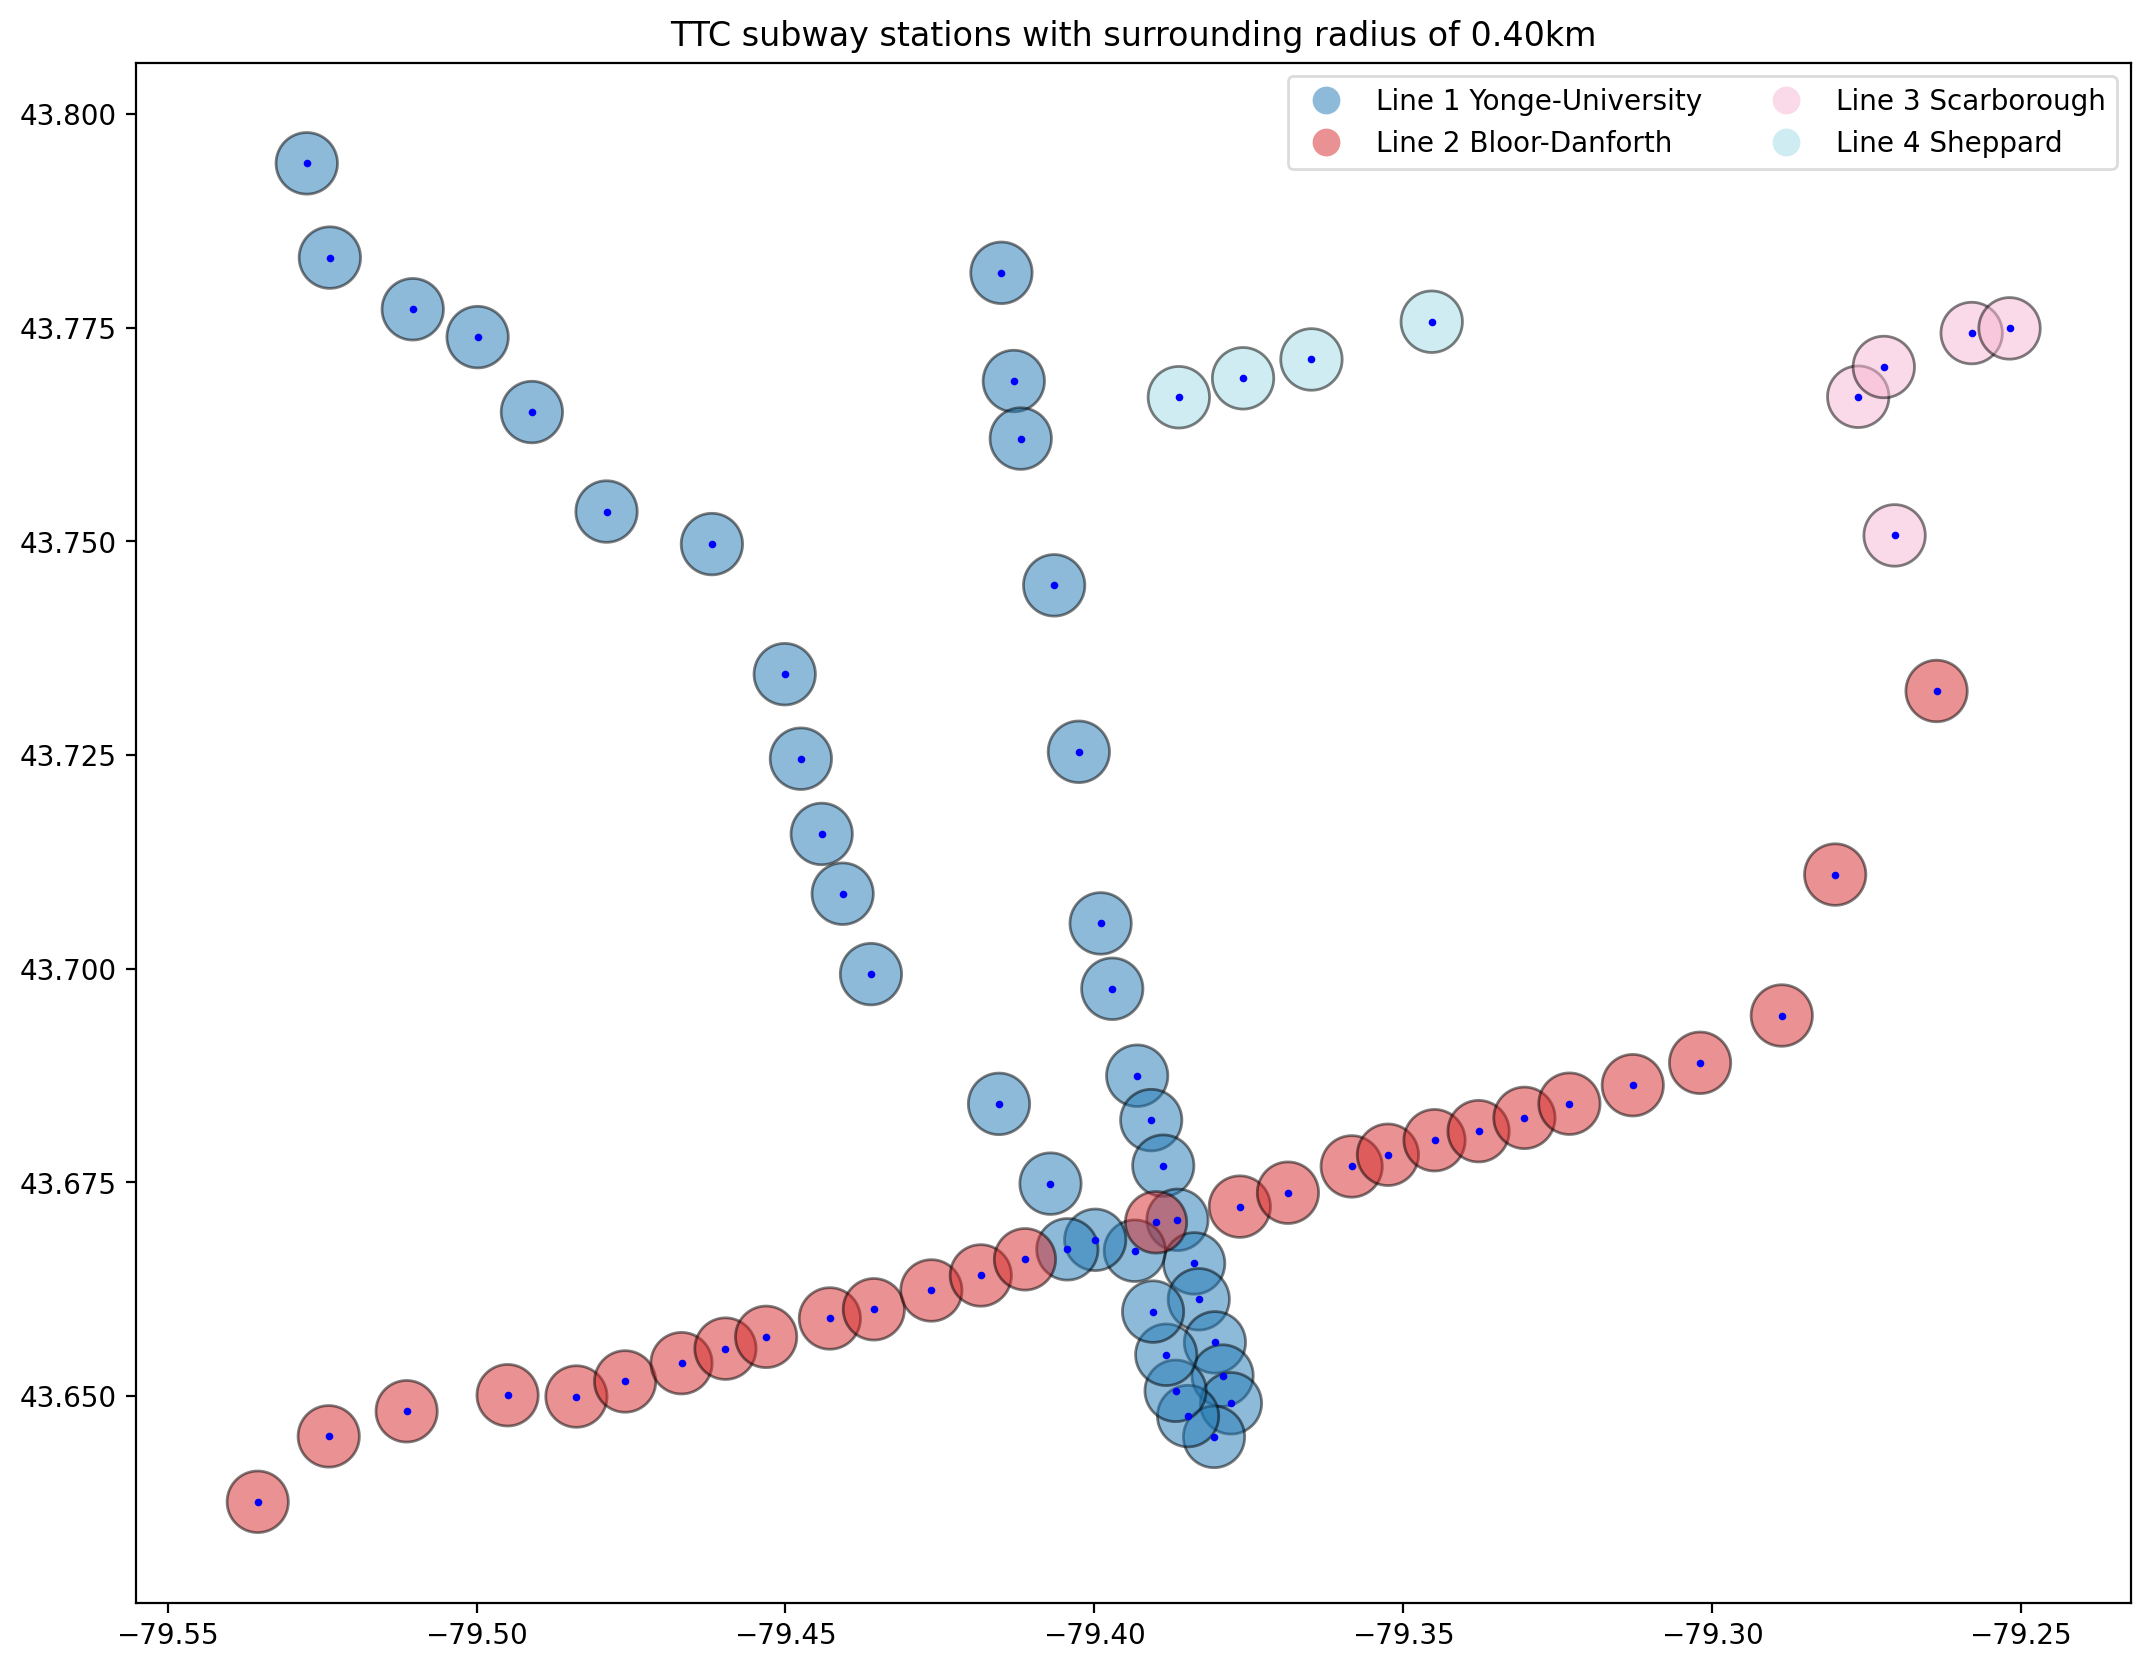

In [16]:
ax = stations_area.plot(column = 'line', 
                        edgecolor = 'black', 
                        alpha = 0.5,
                        cmap = 'tab20',
                        legend = True,
                        legend_kwds = {'loc': 'upper right', 
                                       'ncol': 2,
                                       'edgecolor': 'lightgrey'})
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

plt.title(f'TTC subway stations with surrounding radius of {radius:0.2f}km')

# Neighbourhood population and distance from UofT

In [8]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')
neighbourhoods.head()

,neighbourhood,hood_id,occurrence_year,distance_km,district,population,area,geometry
0,West Humber-Clairville,1,2014,17.220696,W10,34745,30.145103,"POLYGON ((-79.55235 43.70947, -79.55237 43.709..."
1,West Humber-Clairville,1,2015,17.220696,W10,34557,30.145103,"POLYGON ((-79.55235 43.70947, -79.55237 43.709..."
2,West Humber-Clairville,1,2016,17.220696,W10,34418,30.145103,"POLYGON ((-79.55235 43.70947, -79.55237 43.709..."
3,West Humber-Clairville,1,2017,17.220696,W10,35085,30.145103,"POLYGON ((-79.55235 43.70947, -79.55237 43.709..."
4,West Humber-Clairville,1,2018,17.220696,W10,35772,30.145103,"POLYGON ((-79.55235 43.70947, -79.55237 43.709..."


Text(0.5, 1.0, 'Toronto Neighbourhoods with hood_id')

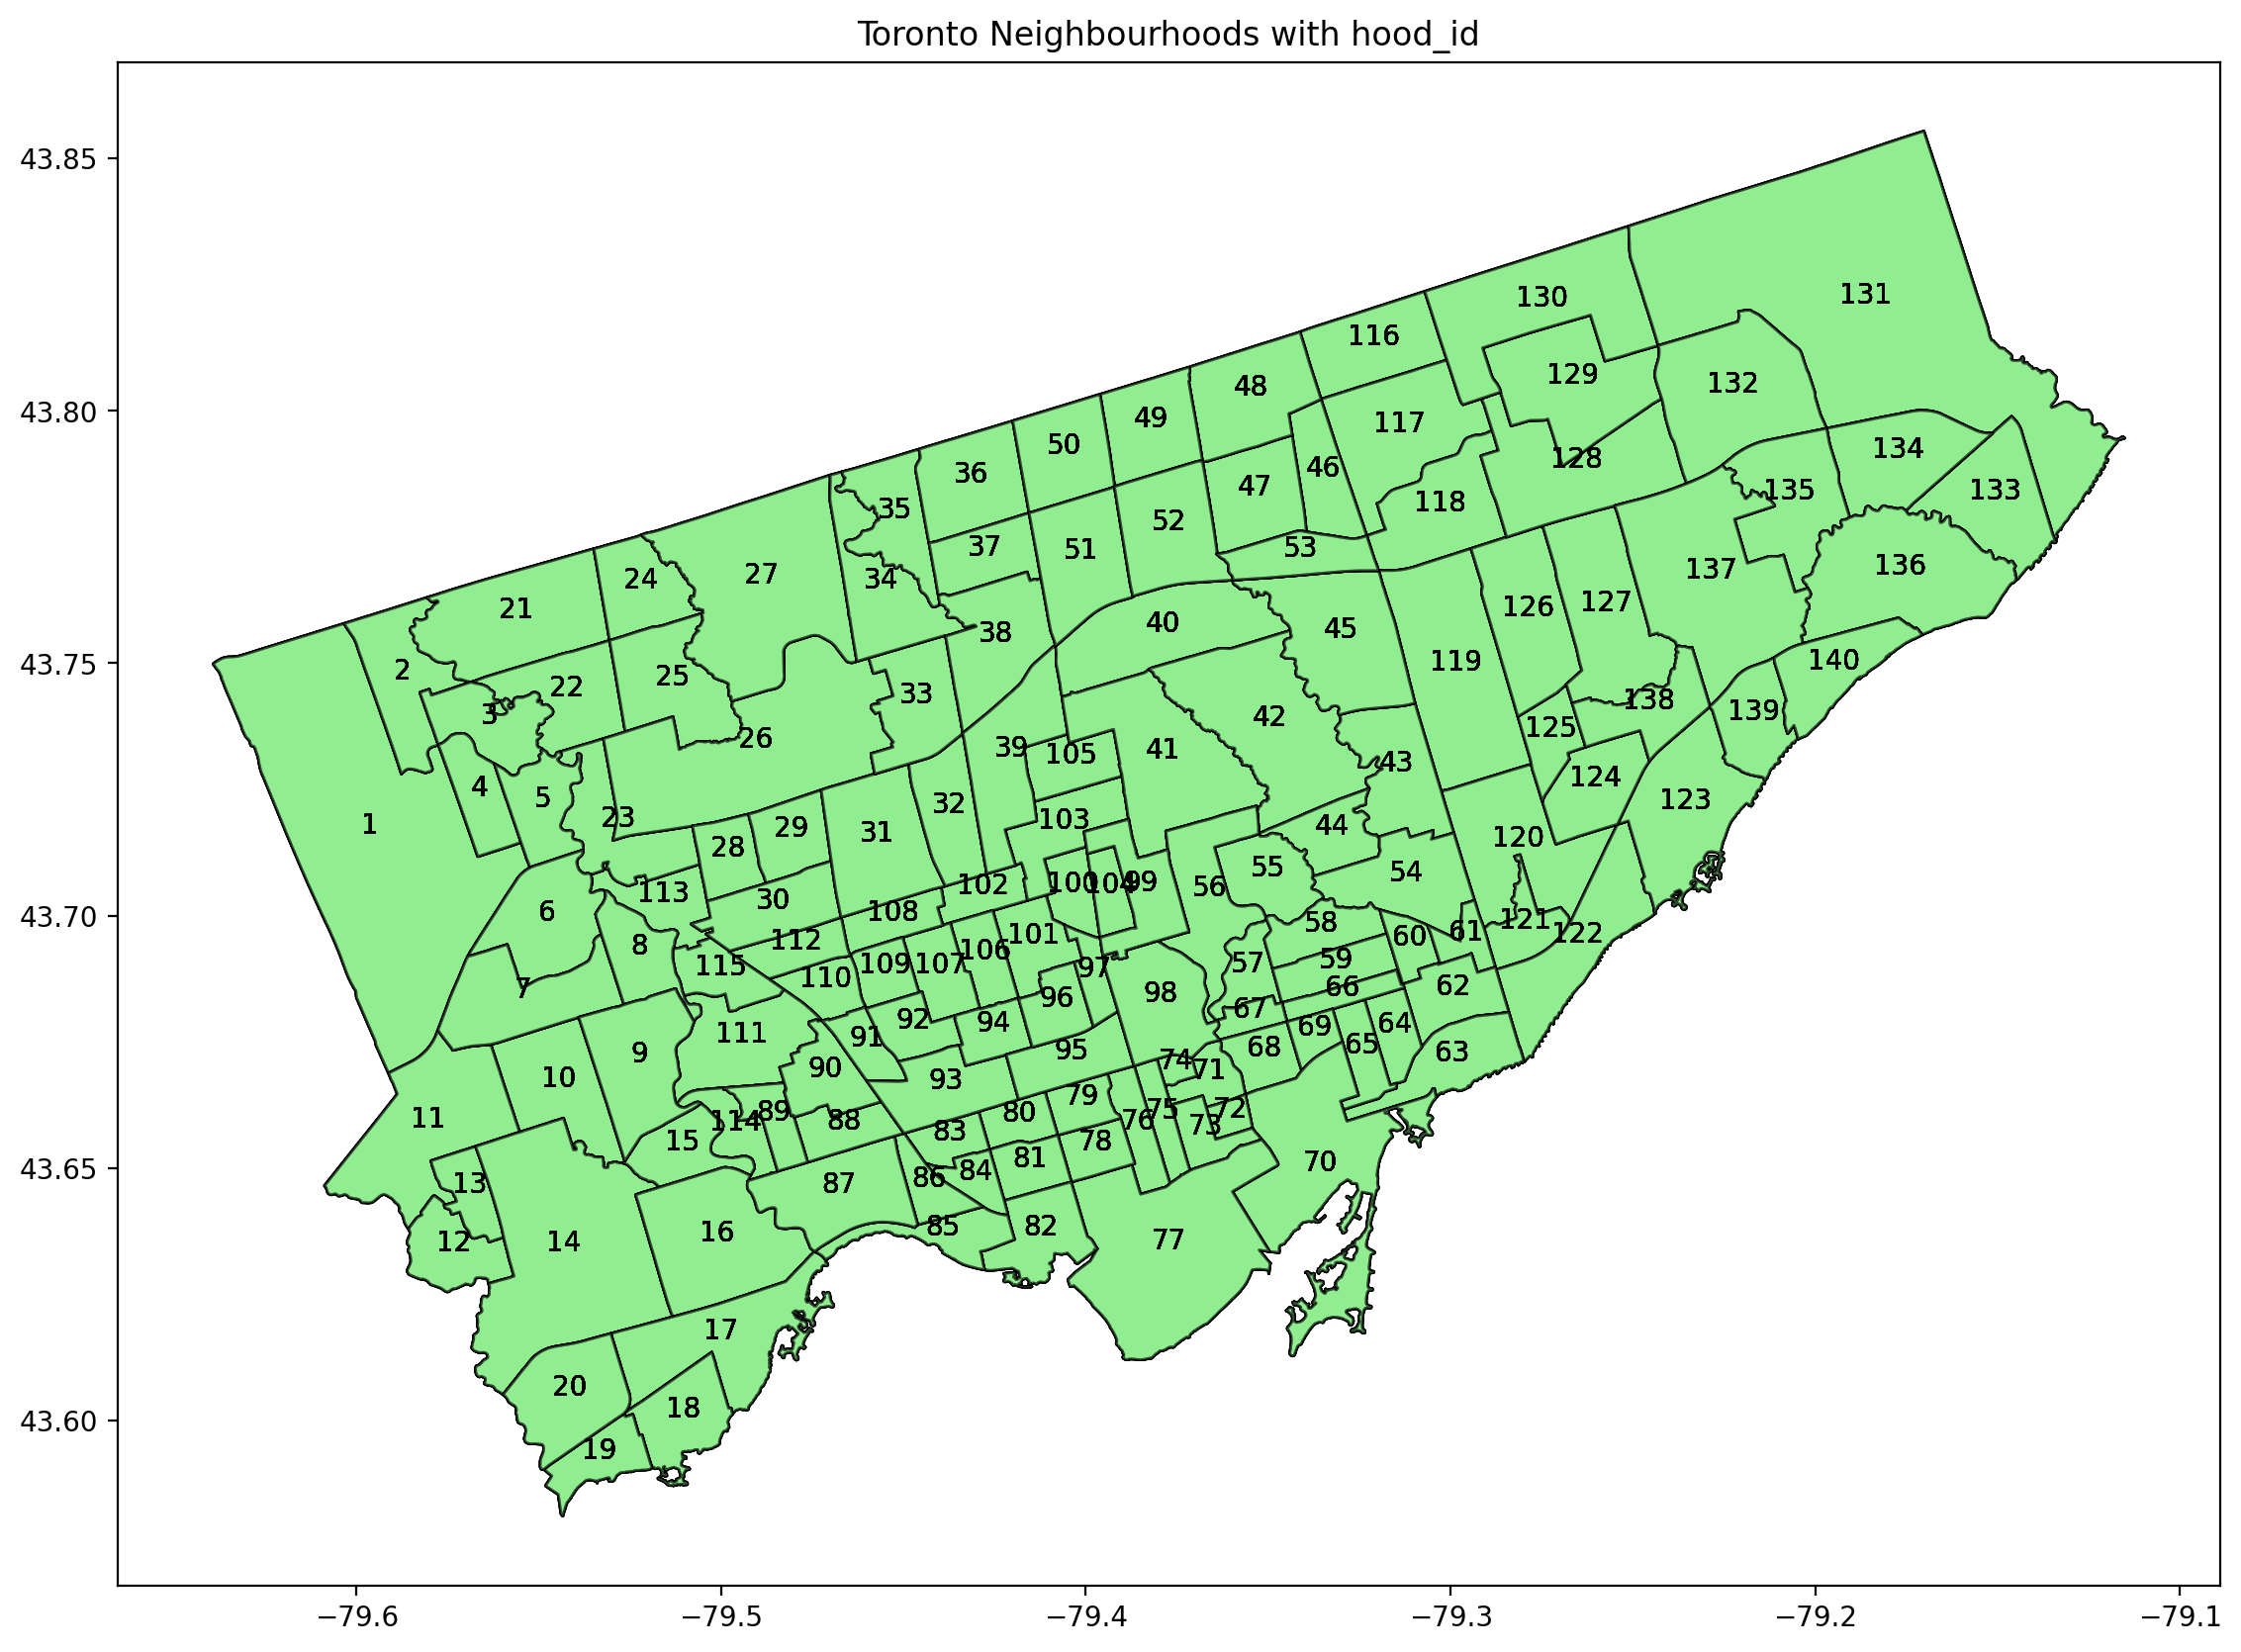

In [10]:
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
# annotate neighbourhood names
for geometry, label in zip(neighbourhoods.geometry, neighbourhoods.hood_id):
    ax.annotate(label, xy=(geometry.centroid.x, geometry.centroid.y), ha='center')
    
plt.title('Toronto Neighbourhoods with hood_id')

Text(0.5, 1.0, 'Distance in km from University of Toronto St. George campus')

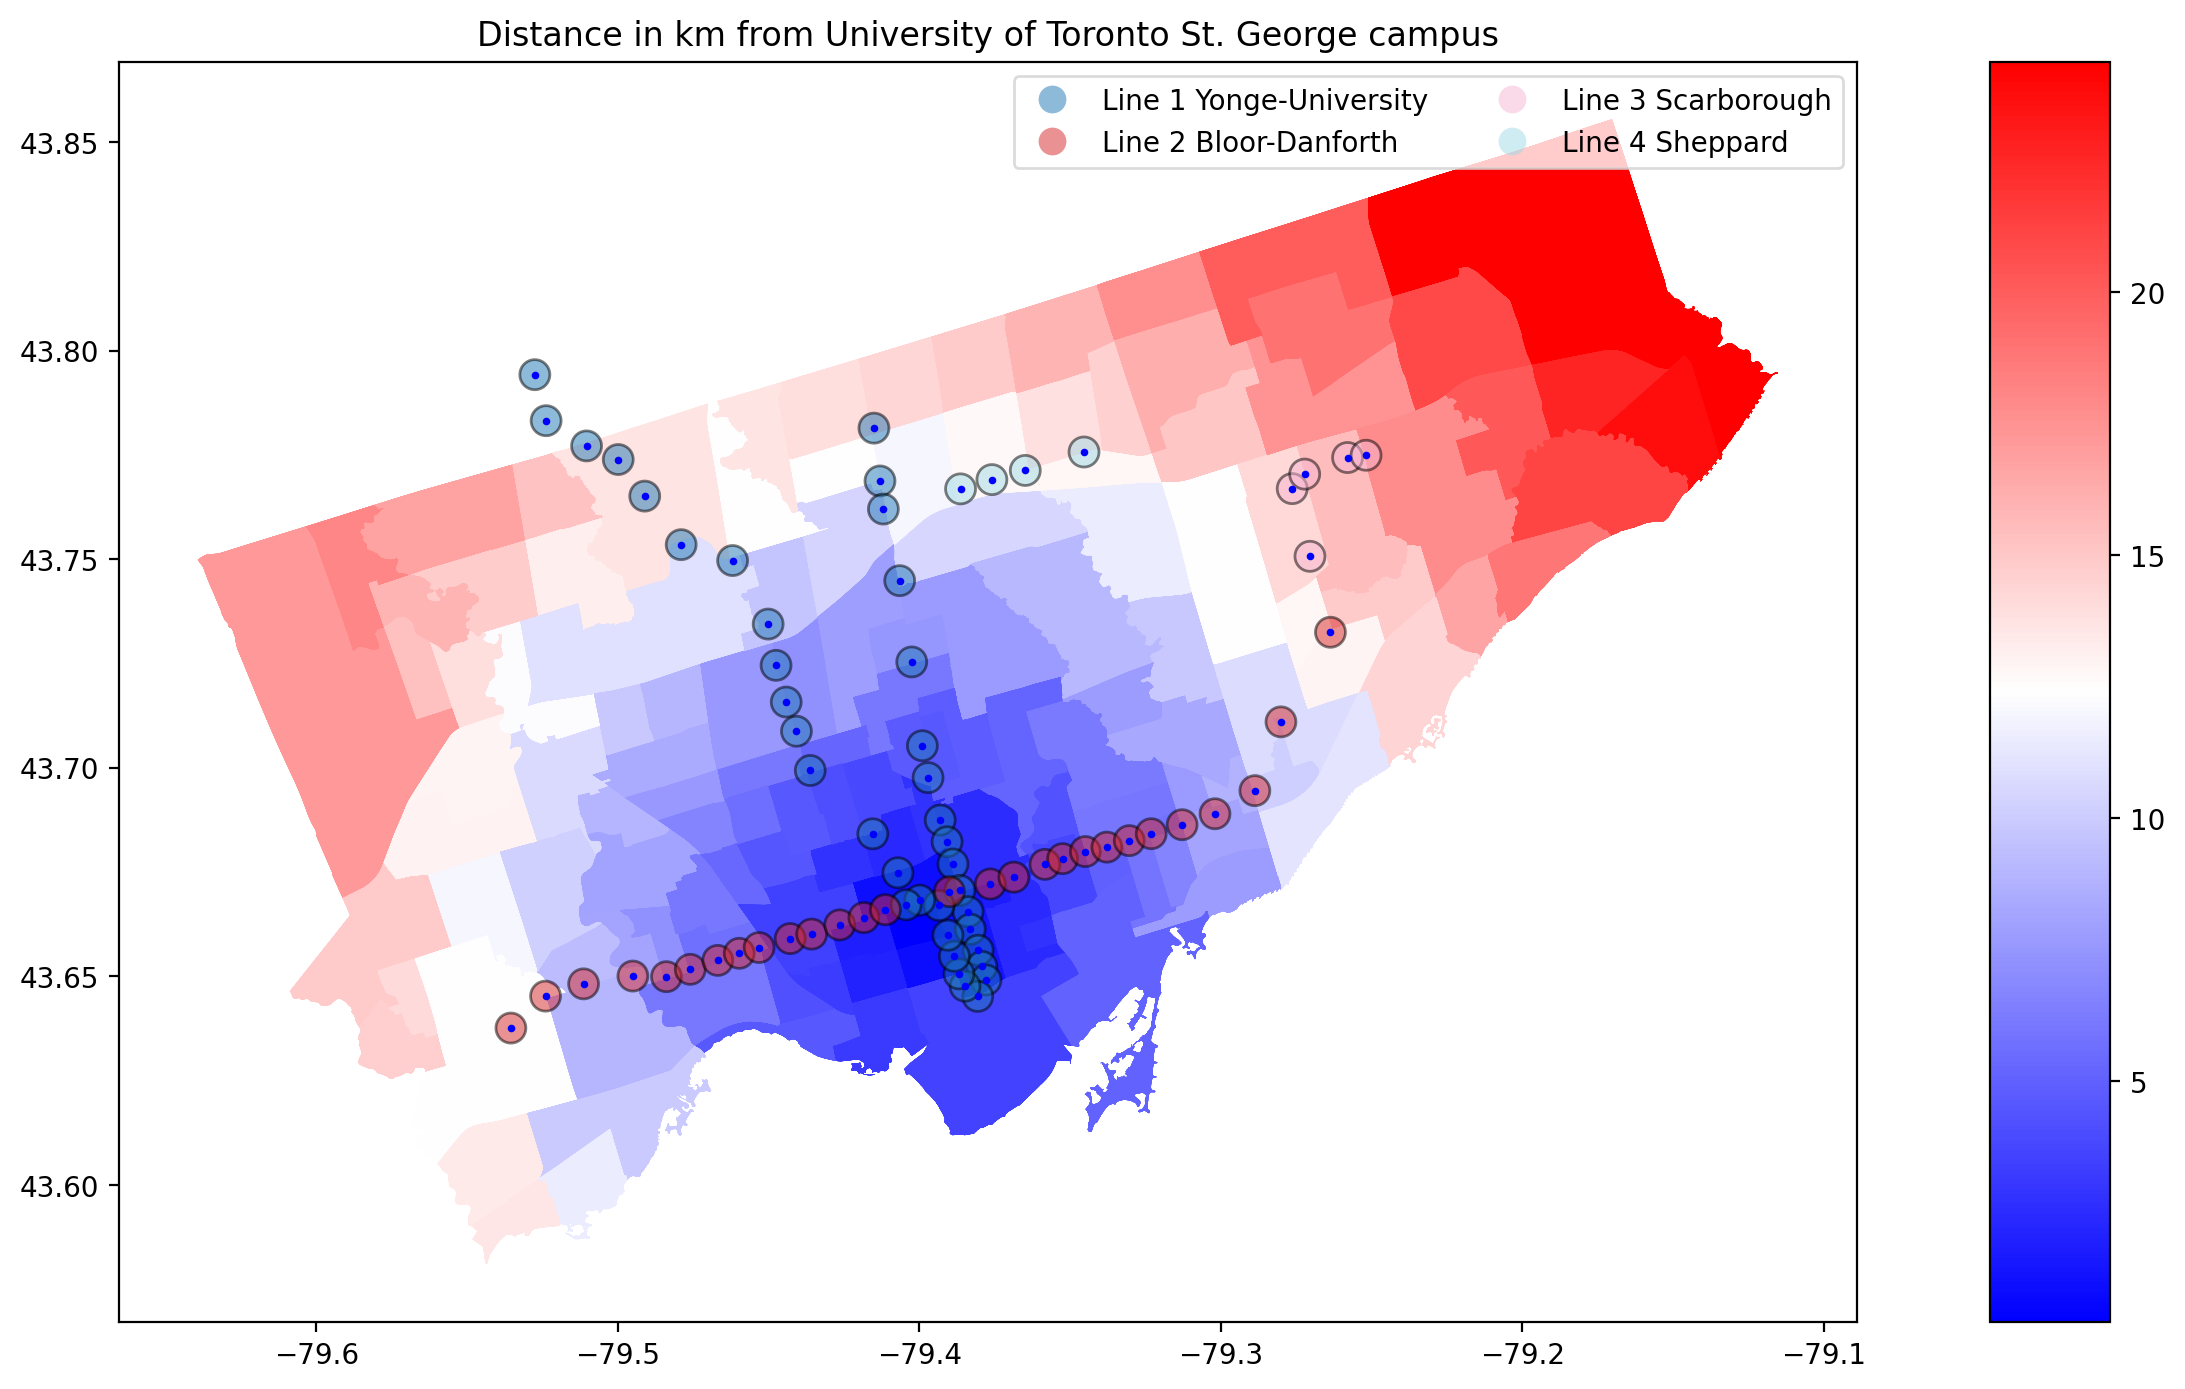

In [17]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-1)
im2 = neighbourhoods.plot(column = 'distance_km', 
                         cmap = 'bwr',
                         legend = True,
                         ax = ax,
                         cax = cax)
stations_area.plot(ax = ax,
                   column = 'line', 
                   edgecolor = 'black', 
                    alpha = 0.5,
                    cmap = 'tab20',
                    legend = True,
                    legend_kwds = {'loc': 'upper right', 
                                    'ncol': 2,
                                    'edgecolor': 'lightgrey'})
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)
ax.set_title('Distance in km from University of Toronto St. George campus')

# Load Person-In-Crisis and Mental Health Apprehensions

In [53]:
pic_mha = pd.read_csv('../data/processed/pic_mha.csv')

In [54]:
pic_mha.head()

,neighbourhood,hood_id,occurrence_year,area,population,type,PersonInCrisis,MentalHealth
0,West Humber-Clairville,1,2014,30.145103,34745,count,342.0,91.0
1,West Humber-Clairville,1,2015,30.145103,34557,count,440.0,144.0
2,West Humber-Clairville,1,2016,30.145103,34418,count,482.0,145.0
3,West Humber-Clairville,1,2017,30.145103,35085,count,440.0,149.0
4,West Humber-Clairville,1,2018,30.145103,35772,count,549.0,195.0


In [55]:
pic_mha.hood_id = pic_mha.hood_id.astype(str)

In [68]:
pic_mha_merge = pic_mha.merge(neighbourhoods[['hood_id', 'geometry']], on = 'hood_id', how = 'inner')

In [69]:
pic_mha_merge = gpd.GeoDataFrame(pic_mha_merge, geometry = 'geometry', crs = epsg_3d)

In [71]:
def plot_one(var, var_type, title, row, col):
    fig, axes = plt.subplots(row, col)

    # fix the range for the colorbar so we can compare across years
    vmin, vmax = pic_mha_merge.loc[pic_mha_merge['type'] == var_type, var].min(), pic_mha_merge.loc[pic_mha_merge['type'] == var_type, var].max()
    norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)
    
    for ax in axes.flatten():
        ax.xaxis.set_visible(False)
        ax.set_yticks([])
    
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.05, 0.8])
    for year, ax in zip(pic_mha_merge['occurrence_year'].unique(), axes.flatten()):
        pic_mha_merge.loc[(pic_mha_merge['type'] == var_type) & (pic_mha_merge['occurrence_year'] == year)].plot(
            column = var, 
            cmap = 'bwr',
            norm = norm,
            ax = ax, 
                            # cax = cax,
                            # legend = True,
        )
        ax.set_title(year)

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='bwr'), cax=cax, orientation='vertical')
    
    fig.suptitle(title, size='xx-large')

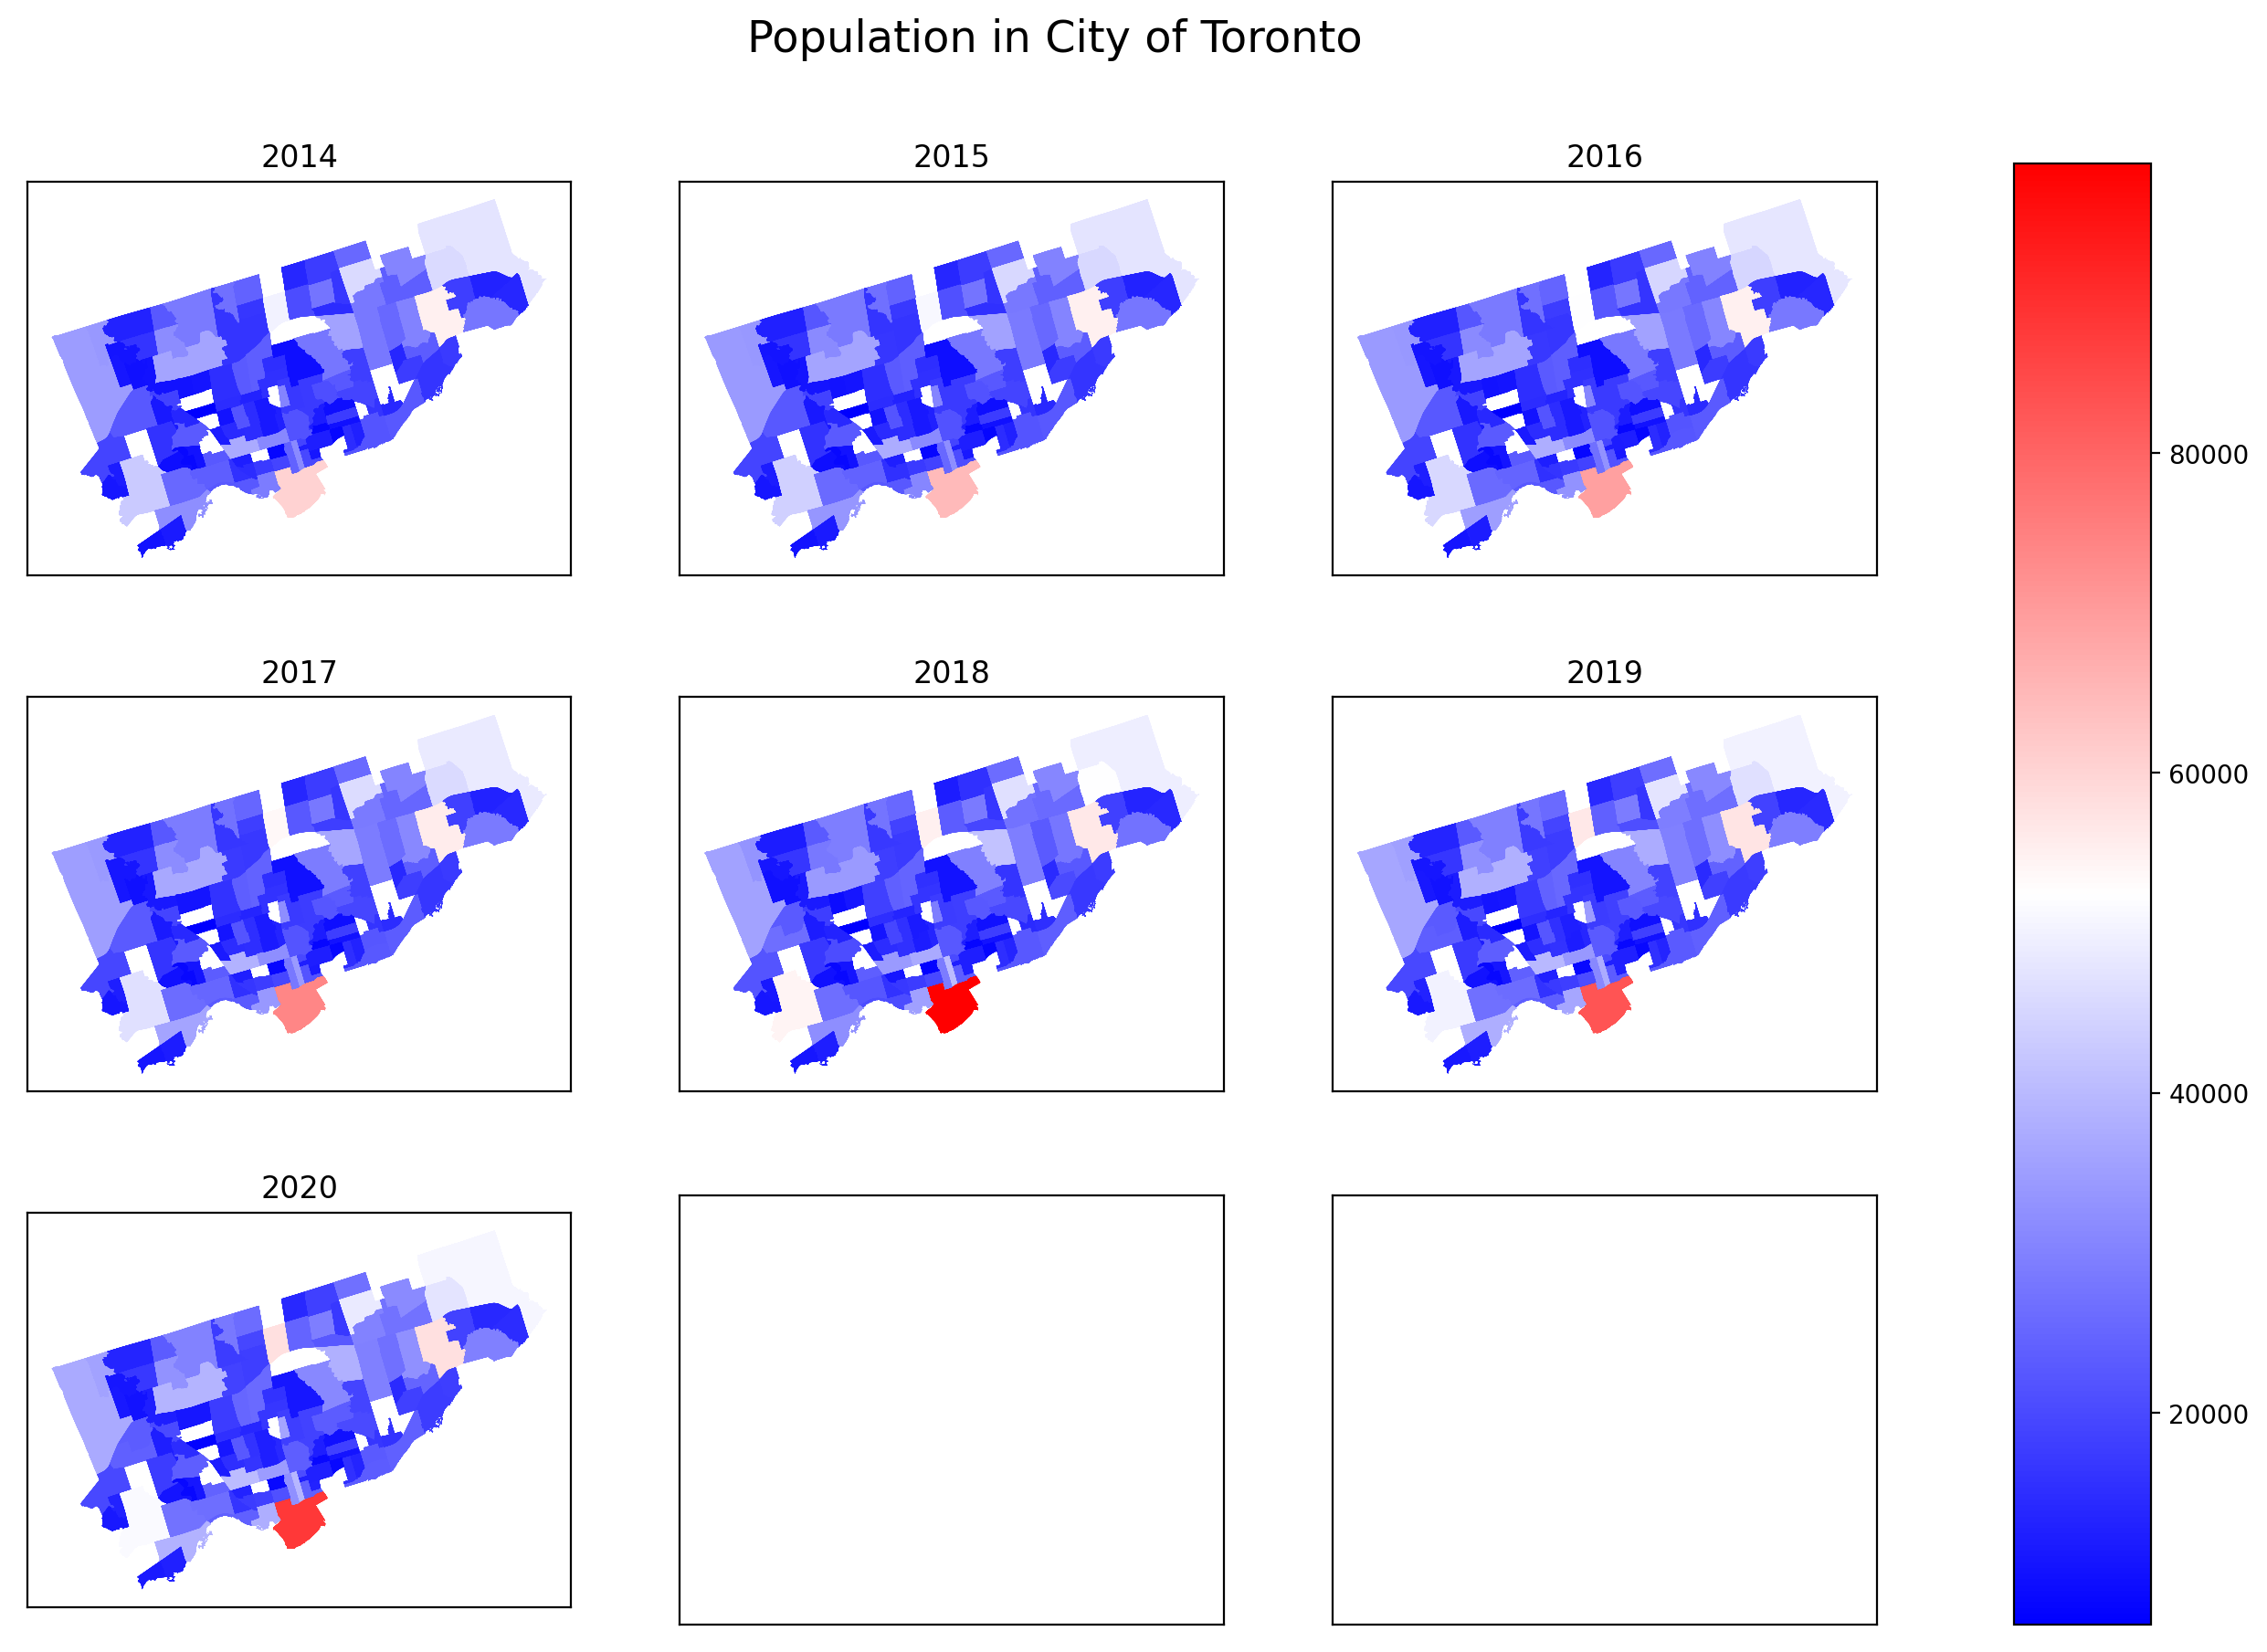

In [72]:
plot_one('population', 'count', 'Population in City of Toronto', 3, 3)

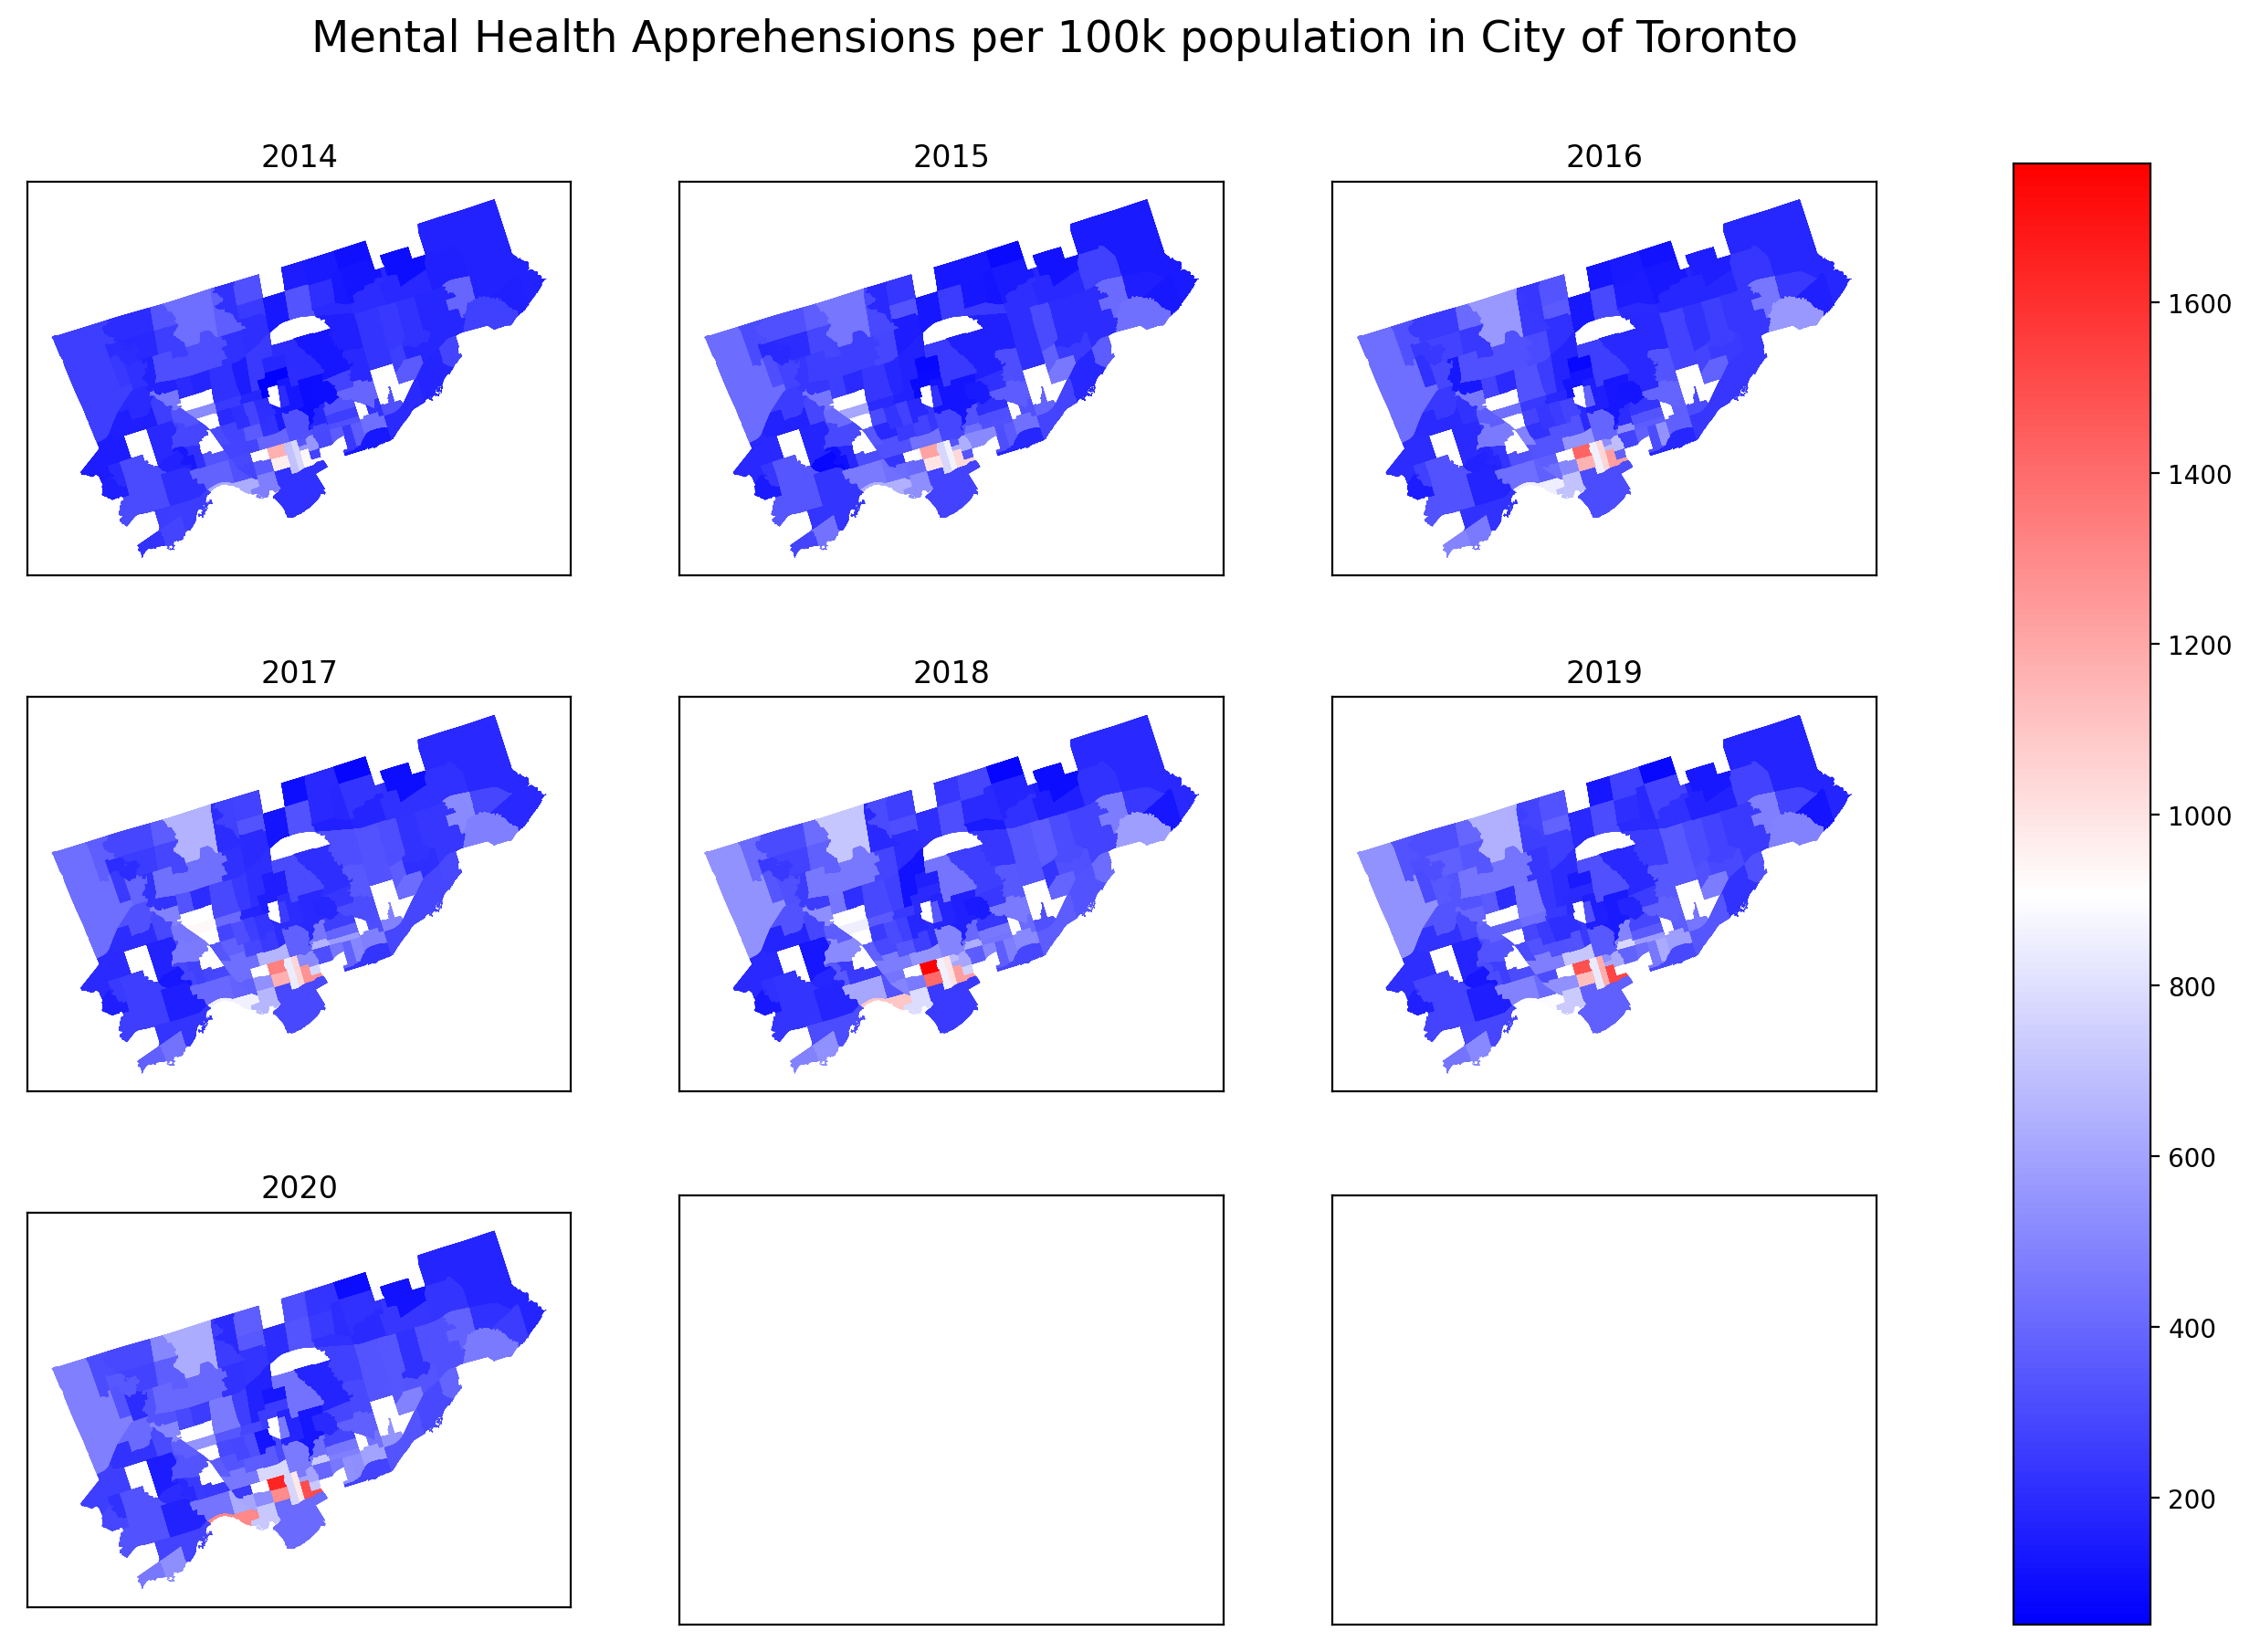

In [35]:
plot_one('MentalHealth', 'rate', 'Mental Health Apprehensions per 100k population in City of Toronto', 3, 3)

147.0311027332705 6086.134273188343


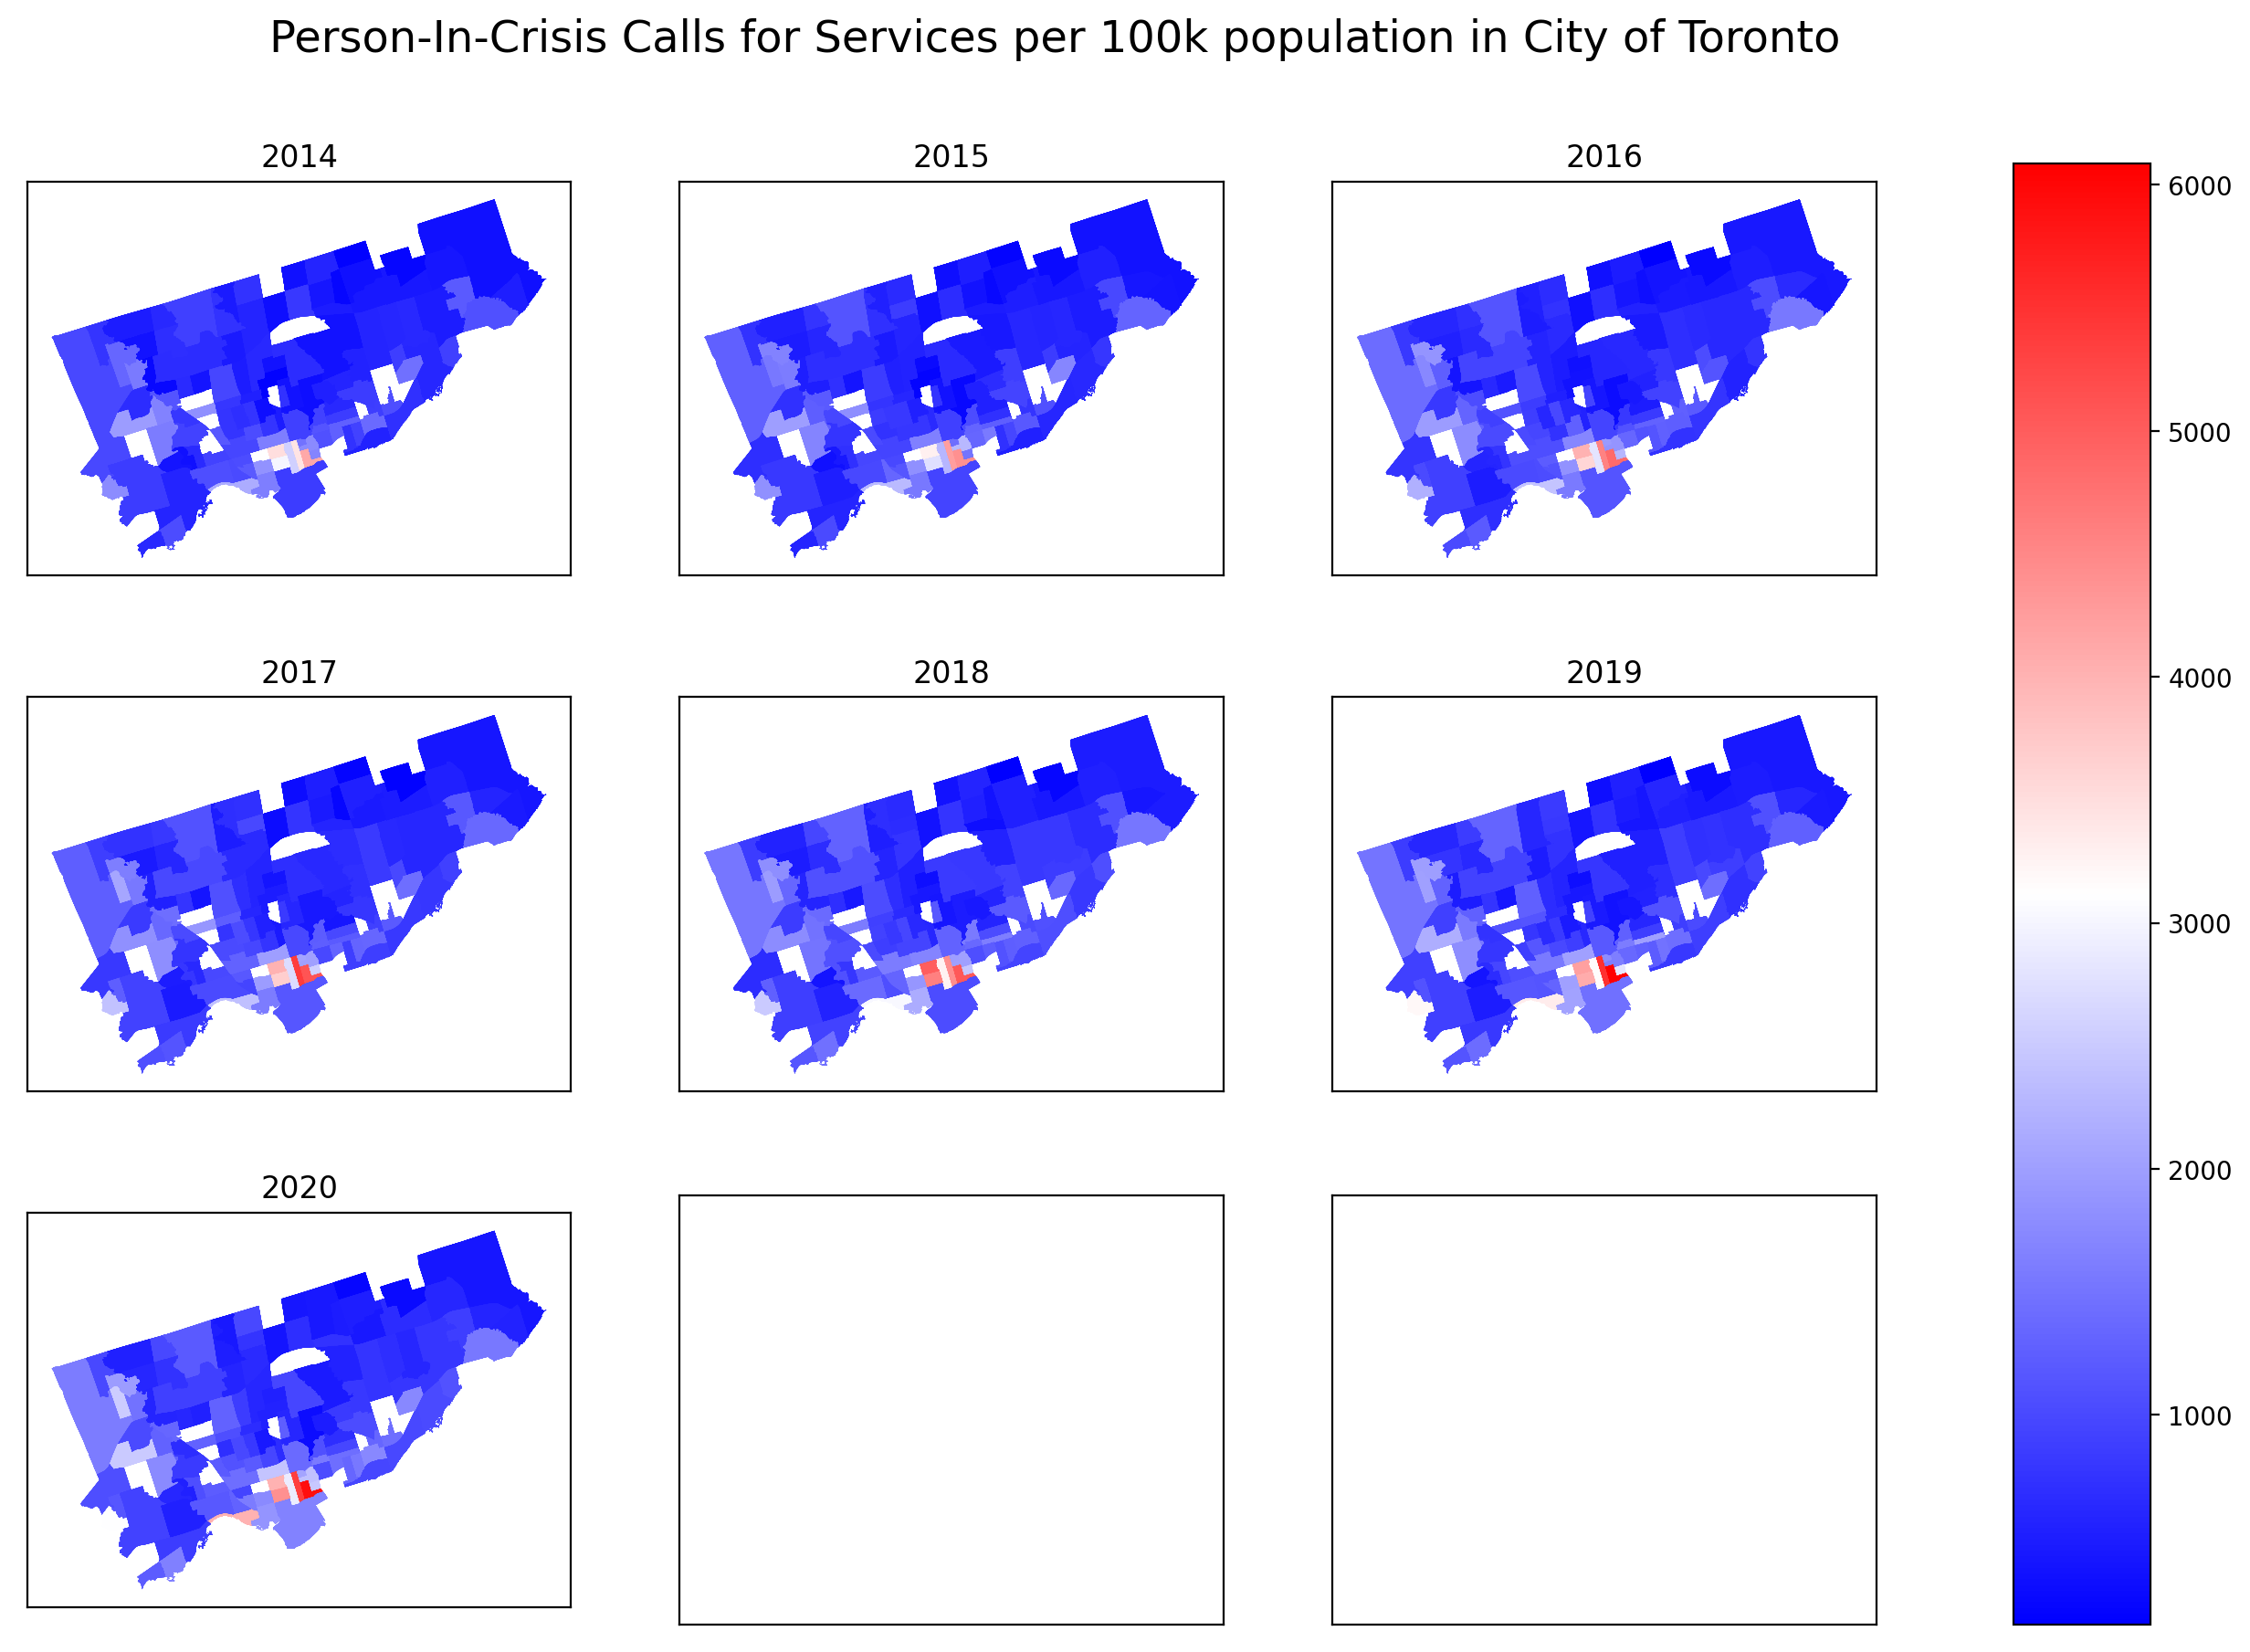

In [40]:
plot_one('PersonInCrisis', 'rate', 'Person-In-Crisis Calls for Services per 100k population in City of Toronto', 3, 3)

In [38]:
pic_mha.isna().sum()

neighbourhood      0
hood_id            0
occurrence_year    0
area               0
population         0
type               0
PersonInCrisis     0
MentalHealth       0
geometry           0
dtype: int64